In [1]:
from bs4 import BeautifulSoup
from urllib import request
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

%matplotlib inline

In [2]:
# reading in data
wikipedia = 'https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'
handler = request.urlopen(wikipedia)
soup = BeautifulSoup(handler.read(), 'html.parser')
table = soup.find_all(class_='wikitable')[0]
df = pd.read_html(str(table), header=0)[0]

# replacing footnotes and other crap
pattern = r'\(.*\)|\[.*\]|\D'
df['Other Source Deaths'] = df['Other Source Deaths'].str.replace(pattern, "")
df['EM-DAT Total Deaths'] = df['EM-DAT Total Deaths'].str.replace(pattern, "")

# replacing magnitude with number
pattern = r'([^\.\d]).*'
df['Magnitude'] = df['Magnitude'].str.replace(pattern, '')

# replacing unclean longs and lats
pattern = r'\?\??'
df['Long'] = df['Long'].replace(pattern, np.nan, regex=True)
df['Lat'] = df['Lat'].replace(pattern, np.nan, regex=True)

# converting to numericdf['Long'] = pd.to_numeric(df['Long'])
df['Lat'] = pd.to_numeric(df['Lat'])
df['Long'] = pd.to_numeric(df['Long'])
df['Magnitude'] = pd.to_numeric(df['Magnitude'])
df['Other Source Deaths'] = pd.to_numeric(df['Other Source Deaths'])
df['PDE Total Deaths'] = pd.to_numeric(df['PDE Total Deaths'])
df['Utsu Total Deaths'] = pd.to_numeric(df['Utsu Total Deaths'])
df['EM-DAT Total Deaths'] = pd.to_numeric(df['EM-DAT Total Deaths'])

# creating new deaths column with max
df['Deaths'] = df[['PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Other Source Deaths']].max(axis=1)
df.columns.values[1] = 'Country'

# cleaning countries
pattern = r'(, ?| ?\().*'
df['Country'] = df['Country'].str.replace(pattern, '')

HBox(children=(FloatRangeSlider(value=(0.0, 1.7), continuous_update=False, description='Magnitude', max=10.0), Dropdown(description='Country', index=18, options=('ALL', 'Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Azerbaijan', 'Bangladesh', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burma', 'Burundi', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England', 'Eritrea', 'Ethiopia', 'Fiji', 'France', 'Georgia', 'Ghana', 'Greece', 'Guadeloupe', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Judea and Samaria', 'Kazakhstan', 'Kingdom of Yugoslavia', 'Kyrgyzstan', 'Macedonia', 'Malawi', 'Malaysia', 'Mandatory Palestine and Transjordan', 'Martinique', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Pakistan', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Pierre and Miquelon', 'Samoa', 'Saudi Arabia/Egypt', 'Serbia', 'Slovenia', 'Solomon Islands', 'South Africa', 'Spain', 'Sudan', 'Syrian Arab Republic', 'Taiwan', 'Tajik Soviet Socialist Republic', 'Tajikistan', 'Tanzania', 'Tunisia', 'Turkey', 'Turkmenistan', 'US Territory of Alaska', 'Uganda', 'United States', 'United States Minor Outlying Islands', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Wallis and Futuna', 'Yemen', 'Yugoslavia'), value='China')))

Ain't no earthquakes of this magnitude in this area... Try again


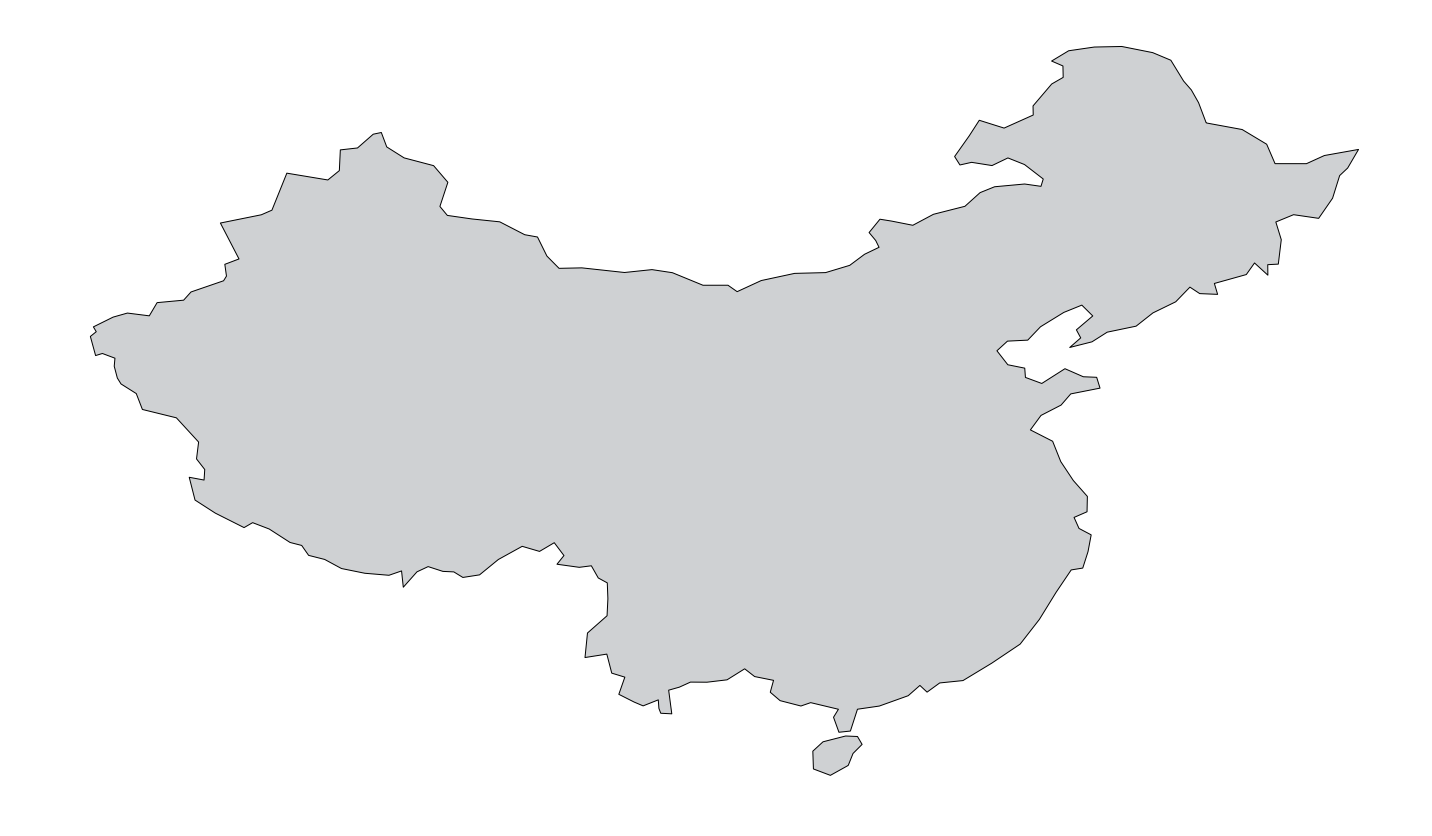

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, clear_output
import warnings

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry = [Point(x) for x in zip(df["Long"], df["Lat"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

countries = sorted(list(set(gdf.Country)))
countries.insert(0, 'ALL')
countries.remove("")

w = widgets.FloatRangeSlider(value=(0,10), min=0, max=10, continuous_update=False, description='Magnitude')
m = widgets.Dropdown(options=countries, value='ALL', description='Country', disabled=False,)
z = widgets.HBox([w,m])
display(z)

ax = world.plot(color='#cfd1d3', edgecolor='black', figsize=(25,55))
ax.axis('off')
gdf.plot(ax=ax, column='Magnitude', alpha=0.4, cmap='seismic', );
fig = ax.get_figure()

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.01)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=2.0, vmax=10.0))
sm._A = []
fig.colorbar(sm,cax=cax)
fig.patch.set_facecolor('#e4f4ff')

maximum = 10
minimum = 0
country = "ALL"
world_copy = world.copy()

def response(change):
    print(change)
    try:
        clear_output(wait=True)
        global country
        global maximum
        global minimum
        global world_copy
        if len(change['new']) == 2:
            maximum = change['new'][1]
            minimum = change['new'][0]
        else:
            country = change['new']
        display(z)

        if country.upper() == 'ALL':
            display_df = gdf[(gdf["Magnitude"] >= minimum) & (gdf['Magnitude'] <= maximum)]
            world_copy = world
        else:
            display_df = gdf[(gdf["Magnitude"] >= minimum) & (gdf['Magnitude'] <= maximum) & (gdf['Country'].str.upper() == country.upper())]
            world_copy = world[world['name'].str.upper() == country.upper()]

        #display_df = gdf[(gdf["Magnitude"] >= minimum) & (gdf['Magnitude'] <= maximum)]


        ax = world_copy.plot(color='#cfd1d3', edgecolor='black', figsize=(25,55))
        ax.axis('off')
        display_df.plot(ax=ax, column='Magnitude', alpha=0.4, cmap='seismic', s=290);
        fig = ax.get_figure()

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.01)

        sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=1.0, vmax=10.0))
        sm._A = []
        fig.colorbar(sm,cax=cax)
        fig.patch.set_facecolor('#e4f4ff')
    except:
        print("Ain't no earthquakes of this magnitude in this area... Try again")
        warnings.filterwarnings('ignore')

    
w.observe(response, names='value')
m.observe(response, names='value')

Dropdown(description='Year', options=('2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990', '1989', '1988', '1987', '1986', '1985', '1984', '1983', '1982', '1981', '1980', '1979', '1978', '1977', '1976', '1975', '1974', '1973', '1972', '1971', '1970', '1969', '1968', '1967', '1966', '1965', '1964', '1963', '1962', '1961', '1960', '1959', '1958', '1957', '1956', '1955', '1954', '1953', '1952', '1951', '1950', '1949', '1948', '1947', '1946', '1945', '1944', '1943', '1942', '1941', '1940', '1939', '1938', '1937', '1936', '1935', '1934', '1933', '1932', '1931', '1930', '1929', '1928', '1927', '1926', '1925', '1924', '1923', '1922', '1921', '1920', '1919', '1918', '1917', '1916', '1915', '1914', '1913', '1912', '1911', '1910', '1909', '1908', '1907', '1906', '1905', '1904', '1903', '1902', '1901', '1900'), value='2011')

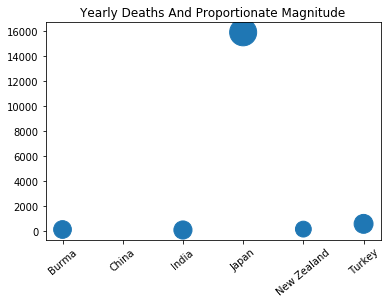

In [4]:
gdf['Year'] = gdf['Origin (UTC)'].str[:4]
years = sorted(list(set(gdf['Year'])))
years.reverse()

yearly = gdf.loc[gdf['Year'] == years[0]]

y = widgets.Dropdown(
    options=years,
    value=years[0],
    description='Year',
    disabled=False)

display(y)

plt.xticks(rotation=40)
plt.title('Yearly Deaths And Proportionate Magnitude')
plt.scatter(x=yearly['Country'], y=yearly['Deaths'], marker='o', s=yearly['Magnitude']**3)

def scatter_response(year_change):
    clear_output(wait=True)
    year = year_change['new']
    yearly = gdf.loc[gdf['Year'] == year]
    display(y)
    plt.xticks(rotation=40)
    plt.title('Yearly Deaths And Proportionate Magnitude')
    plt.scatter(x=yearly['Country'], y=yearly['Deaths'], marker='o', s=yearly['Magnitude']**3)
    
y.observe(scatter_response, names='value')

Dropdown(description='Country', options=('ALL', 'Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Azerbaijan', 'Bangladesh', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burma', 'Burundi', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England', 'Eritrea', 'Ethiopia', 'Fiji', 'France', 'Georgia', 'Ghana', 'Greece', 'Guadeloupe', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Judea and Samaria', 'Kazakhstan', 'Kingdom of Yugoslavia', 'Kyrgyzstan', 'Macedonia', 'Malawi', 'Malaysia', 'Mandatory Palestine and Transjordan', 'Martinique', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Pakistan', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Pierre and Miquelon', 'Samoa', 'Saudi Arabia/Egypt', 'Serbia', 'Slovenia', 'Solomon Islands', 'South Africa', 'Spain', 'Sudan', 'Syrian Arab Republic', 'Taiwan', 'Tajik Soviet Socialist Republic', 'Tajikistan', 'Tanzania', 'Tunisia', 'Turkey', 'Turkmenistan', 'US Territory of Alaska', 'Uganda', 'United States', 'United States Minor Outlying Islands', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Wallis and Futuna', 'Yemen', 'Yugoslavia'), value='ALL')

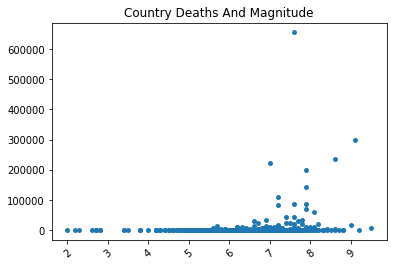

In [5]:
c_gdf = gdf.copy()

c = widgets.Dropdown(options=countries, value='ALL', description='Country', disabled=False,)

display(c)

plt.xticks(rotation=40)
plt.title('Country Deaths And Magnitude')
plt.scatter(x=c_gdf['Magnitude'], y=c_gdf['Deaths'], marker='o', s=15)

def magnitude_response(country_change):
    clear_output(wait=True)
    country = country_change['new']
    if country.upper() == 'ALL':
        c_gdf = gdf.copy()
    else:
        c_gdf = gdf.loc[gdf['Country'].str.upper() == country.upper()]
    display(c)
    plt.xticks(rotation=40)
    plt.title('Yearly Deaths And Proportionate Magnitude')
    plt.scatter(x=c_gdf['Magnitude'], y=c_gdf['Deaths'], marker='o', s=15)
    
c.observe(magnitude_response, names='value')